<a href="https://colab.research.google.com/github/shahjalalkhan16/ml_learning/blob/main/85_43_for_30percant_noise_Co_Teaching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━

In [2]:
import pennylane as qml
import medmnist
from medmnist import OrganAMNIST as DATASETS
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, ConcatDataset, Subset
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import os
import random
from tqdm import tqdm

In [3]:
BATCH_SIZE = 64
Epochs = 20
# lr = 0.1
noise_rate = 0.5
# quality = 0.5

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)


In [4]:
# import random
# import numpy as np
# import torch
# import os

# def set_seed(seed=0):
#     # Basic seeds
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     os.environ["PYTHONHASHSEED"] = str(seed)

#     # CUDA/cuDNN
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed)
#         torch.cuda.manual_seed_all(seed)
#         torch.backends.cudnn.deterministic = True
#         torch.backends.cudnn.benchmark = False
# # Call this at the start of your script
# set_seed(0)


In [5]:
# Step 2: Load and preprocess data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean =[0.5], std=[0.5])
])

In [6]:
# Load datasets
train_dataset = DATASETS(split='train', transform=transform, download=True)
val_dataset = DATASETS(split='val', transform=transform, download=True)
test_dataset = DATASETS(split='test', transform=transform, download=True)

# Concatenate datasets
full_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])
all_labels = np.array([sample[1] for sample in full_dataset]).flatten()

# Balance dataset
class_counts = Counter(all_labels)
min_class_count = min(class_counts.values())
balanced_indices = []

for cls in class_counts.keys():
    cls_indices = np.where(all_labels == cls)[0]
    selected_indices = np.random.choice(cls_indices, min_class_count, replace=False)
    balanced_indices.extend(selected_indices)

balanced_dataset = Subset(full_dataset, balanced_indices)

# Define split sizes
train_size = int(0.7 * len(balanced_dataset))
val_size = int(0.15 * len(balanced_dataset))
test_size = len(balanced_dataset) - train_size - val_size

# Perform dataset split
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    balanced_dataset, [train_size, val_size, test_size]
)

# Define class for introducing noisy labels
class NoisyMedMNIST(Dataset):
    def __init__(self, dataset, noise_ratio=noise_rate):
        self.dataset = dataset
        self.noise_ratio = noise_ratio
        self.noisy_labels = self.apply_label_noise()

    def apply_label_noise(self):
        labels = np.array([sample[1] for sample in self.dataset])
        n_samples = len(labels)
        n_noisy = int(n_samples * self.noise_ratio)
        noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)

        num_classes = len(np.unique(labels))
        for idx in noisy_indices:
            original_label = labels[idx]
            possible_labels = [l for l in range(num_classes) if l != original_label]
            labels[idx] = np.random.choice(possible_labels)
        return labels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        label = self.noisy_labels[idx]
        return image, label

# Apply noisy labels to training dataset
noisy_train_dataset = NoisyMedMNIST(train_dataset, noise_ratio=noise_rate)

# Create DataLoaders
train_loader = DataLoader(noisy_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print dataset sizes
print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

100%|██████████| 38.2M/38.2M [00:23<00:00, 1.60MB/s]


Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Train samples: 18287, Validation samples: 3918, Test samples: 3920


In [7]:
# Print original and noisy labels for verification
print("Original Labels:", np.array([train_dataset[idx][1] for idx in range(10)]))
print("Noisy Labels:", noisy_train_dataset.noisy_labels[:10])


Original Labels: [[9]
 [3]
 [0]
 [3]
 [2]
 [2]
 [3]
 [6]
 [4]
 [0]]
Noisy Labels: [[ 9]
 [ 0]
 [ 1]
 [10]
 [ 2]
 [ 2]
 [ 3]
 [10]
 [ 7]
 [ 0]]


In [8]:
n_qubits = 8
n_layers = 6
dev = qml.device('default.qubit', wires=n_qubits)
# dev = qml.device("default.mixed", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):

    # Embed classical data into quantum state (with padding if needed)
    qml.templates.AmplitudeEmbedding(inputs, wires=range(n_qubits), pad_with=0.0, normalize=True)
    # qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='X')

    # Initial Encoder
    for i in range(n_qubits):
        qml.RX(weights[0, i, 0], wires=i)
        qml.RY(weights[0, i, 1], wires=i)
        # qml.PauliX(wires=i)
        qml.RZ(weights[1, i, 0], wires=i)

    for i in range(n_layers):
        qml.CNOT(wires=[i % n_qubits, (i + 1) % n_qubits])
        # qml.RZ(weights[2, i, 0], wires=i % n_qubits)
        # qml.RX(weights[2, i, 1], wires=i % n_qubits)

    # Entangling layers
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, (i + 2) % n_qubits])


    # Hierarchical Quantum Convolutional Layer (HQCL)
    for i in range(n_layers):
        #Entangling Quantum Convolutional Layer
        for j in range(n_qubits):
            qml.RY(weights[i, j, 0], wires=j)
            qml.CY(wires=[j, (j + 1) % n_qubits])
            qml.RZ(weights[i, j, 1], wires=j)
        qml.CNOT(wires = [i % n_qubits, (i + 1) % n_qubits])
        qml.Hadamard(wires=i)

        #Quantum Convolutional layers
        for j in range(n_qubits):
            qml.RX(weights[i, j, 0], wires=j)
            qml.RY(weights[i, j, 1], wires=j)
            qml.CNOT(wires=[j, (j + 1) % n_qubits])  # Circular entanglement

    #Custom Entangling with Quantum Convolutional Layer
    for j in range(n_qubits):
        qml.RX(weights[i, j, 0], wires=j)
        qml.CNOT(wires=[j, (j + 1) % n_qubits])
        qml.RZ(weights[i, j, 1], wires=j)

    # Adaptive Quantum Pooling
    phi_values = [weights[2, i, 0] for i in range(n_qubits // 2)]

    for i in range(n_qubits // 2):
        phi = torch.tensor([0.2*i], requires_grad=True)
        qml.CNOT(wires=[i, n_qubits - 1 - i])
        qml.RY(phi, wires=n_qubits - 1 - i)
        qml.RY(phi_values[i], wires=n_qubits - 1 - i)
        qml.CNOT(wires=[i, n_qubits - 1 - i])

    # Quantum AttenuFouritation(Attenuation+RZ rotation+Fourier)
    for i in range(n_qubits):
        qml.Toffoli(wires=[i, (i+1) % n_qubits, (i+2) % n_qubits])  # Multi-controlled attention mechanism
        qml.RX(np.pi/2, wires=i)
        for j in range(i):
            qml.CPhase(np.pi / (2 ** (i - j)), wires=[j, i])  # Controlled phase rotation
        qml.Hadamard(wires=i)   # Fourier Transform

    # for i in range(n_qubits):
    #     # qml.CSWAP(wires=[i, (i+1) % n_qubits, (i+2) % n_qubits])  # Multi-controlled swap
    #     qml.SISWAP(wires=[i, (i+1) % n_qubits])  # Multi-controlled swap
    #     qml.RY(np.pi/2, wires=i)
    #     qml.RX(np.pi/2, wires=i)
    #     qml.RZ(np.pi/2, wires=i)

    qml.RX(np.pi, wires=0)
    qml.RY(np.pi, wires= 1)
    qml.RZ(np.pi, wires=2)
    qml.CNOT(wires=[0, 1])


    # Measure PauliZ and PauliX for more varied information
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)] + [qml.expval(qml.PauliX(i)) for i in range(n_qubits)]

# Define the weight shapes for the quantum circuit
weight_shapes = {
    "weights": (n_layers, n_qubits, 3)
}

In [9]:
class SimpleQNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleQNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128*7*7, 64)
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        self.fc2 = nn.Linear(n_qubits*2, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.quantum_layer(x)
        x = self.fc2(x)
        return x

In [10]:
class PureQNN(nn.Module):
    def __init__(self, num_classes):
        super(PureQNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 64) #modified to output 64
        self.relu = nn.ReLU()

        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        self.fc = nn.Linear(n_qubits*2, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.q_layer(x)
        return self.fc(x)

In [11]:
modelA = SimpleQNN(num_classes=11).to(device)
modelB = PureQNN(num_classes=11).to(device)
modelC = PureQNN(num_classes=11).to(device)
criterion = nn.CrossEntropyLoss()
optimizerA = torch.optim.Adam(modelA.parameters(), lr=0.0003)
optimizerB = torch.optim.Adam(modelB.parameters(), lr=0.0003)


In [12]:
def rank_pruning(outputs, labels, keep_ratio=0.8):
    """
    Removes the most uncertain samples using confidence scores.
    Ensures at least 20% of the batch is kept.
    """
    confidence_scores = torch.max(torch.softmax(outputs, dim=1), dim=1)[0]

    # Ensure at least 20% of samples are always used
    min_keep = max(int(len(confidence_scores) * 0.2), 1)

    threshold = torch.quantile(confidence_scores, max(1 - keep_ratio, 0.2))  # Avoiding NaN by keeping min 20%
    mask = confidence_scores >= threshold

    if mask.sum() < min_keep:
        sorted_conf = torch.sort(confidence_scores, descending=True)[0]
        threshold = sorted_conf[min_keep - 1]  # Take the 20% highest confidence
        mask = confidence_scores >= threshold

    return mask


In [13]:
# Forgetting Rate Scheduler (Increasing Noise Filter Over Time)
def forget_rate_scheduler(epoch, max_epochs, initial_keep_ratio=0.8, final_keep_ratio=0.5):
    """Gradually reduces the keep ratio as training progresses."""
    return max(final_keep_ratio, initial_keep_ratio - (epoch / max_epochs) * (initial_keep_ratio - final_keep_ratio))

# Rank Pruning (Confidence-Based Selection)
def rank_pruning(outputs, labels, keep_ratio=0.8):
    """
    Removes the most uncertain samples using confidence scores.
    Ensures at least 20% of the batch is kept.
    """
    confidence_scores = torch.max(torch.softmax(outputs, dim=1), dim=1)[0]

    # Ensure at least 20% of samples are always used
    min_keep = max(int(len(confidence_scores) * 0.2), 1)

    threshold = torch.quantile(confidence_scores, max(1 - keep_ratio, 0.2))  # Avoid NaN by keeping min 20%
    mask = confidence_scores >= threshold

    if mask.sum() < min_keep:
        sorted_conf = torch.sort(confidence_scores, descending=True)[0]
        threshold = sorted_conf[min_keep - 1]  # Take the 20% highest confidence
        mask = confidence_scores >= threshold

    return mask

In [14]:
# Custom Symmetric Cross-Entropy Loss
class SymmetricCrossEntropyLoss(nn.Module):
    def __init__(self, alpha=0.1):
        super(SymmetricCrossEntropyLoss, self).__init__()
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        num_classes = inputs.size(1)
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=num_classes).float().to(inputs.device)
        inputs_probs = torch.softmax(inputs, dim=1)
        reverse_ce_loss = -(targets_one_hot * torch.log(inputs_probs + 1e-10)).sum(dim=1)
        return ((1 - self.alpha) * ce_loss + self.alpha * reverse_ce_loss).mean()


In [15]:
optimizerA = torch.optim.Adam(modelA.parameters(), lr=0.0003)
optimizerB = torch.optim.Adam(modelB.parameters(), lr=0.0003)
criterion = SymmetricCrossEntropyLoss().to(device)

all_labelsA, all_labelsB = [], []
all_probsA, all_probsB = [], []
all_lossesA, all_lossesB = [], []
all_predictionsA, all_predictionsB = [], []

for epoch in range(Epochs):
    modelA.train()
    modelB.train()

    running_lossA, running_lossB = 0.0, 0.0
    correctA, correctB = 0.0, 0.0

    forget_rate = forget_rate_scheduler(epoch, Epochs)

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.view(-1).long().to(device)

        optimizerA.zero_grad()
        optimizerB.zero_grad()

        # Forward Pass
        outputsA = modelA(images)
        outputsB = modelB(images)

        # Apply dynamic rank pruning
        maskA = rank_pruning(outputsA, labels, keep_ratio=forget_rate)
        maskB = rank_pruning(outputsB, labels, keep_ratio=forget_rate)

        # Apply co-teaching: Each model trains on the other’s selected samples
        if maskA.sum() > 0 and maskB.sum() > 0:
            lossA_filtered = criterion(outputsA[maskB], labels[maskB])
            lossB_filtered = criterion(outputsB[maskA], labels[maskA])
        else:
            lossA_filtered = torch.tensor(0.0, requires_grad=True).to(device)
            lossB_filtered = torch.tensor(0.0, requires_grad=True).to(device)

        # Backpropagation
        lossA_filtered.backward()
        lossB_filtered.backward()
        optimizerA.step()
        optimizerB.step()

        running_lossA += lossA_filtered.item()
        running_lossB += lossB_filtered.item()

        # Compute Accuracy
        _, predictedA = torch.max(outputsA, 1)
        _, predictedB = torch.max(outputsB, 1)

        correctA += (predictedA == labels).sum().item()
        correctB += (predictedB == labels).sum().item()

        all_labelsA.extend(labels.cpu().numpy())
        all_labelsB.extend(labels.cpu().numpy())

        # We now detach the tensor from the computation graph prior to converting to numpy
        all_probsA.extend(outputsA.detach().cpu().numpy()) # detach
        all_probsB.extend(outputsB.detach().cpu().numpy()) # detach

        all_lossesA.append(lossA_filtered.detach().cpu().numpy().item()) # detach and extract scalar
        all_lossesB.append(lossB_filtered.detach().cpu().numpy().item()) # detach and extract scalar


        all_predictionsA.extend(predictedA.cpu().numpy())
        all_predictionsB.extend(predictedB.cpu().numpy())


    # Compute final accuracy
    accuracyA = 100 * correctA / len(train_loader.dataset)
    accuracyB = 100 * correctB / len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{Epochs} - LossA: {running_lossA/len(train_loader):.4f}, LossB: {running_lossB/len(train_loader):.4f}, AccuracyA: {accuracyA:.2f}%, AccuracyB: {accuracyB:.2f}%")


100%|██████████| 286/286 [07:16<00:00,  1.52s/it]


Epoch 1/20 - LossA: 2.3347, LossB: 2.3512, AccuracyA: 24.76%, AccuracyB: 18.63%


100%|██████████| 286/286 [07:22<00:00,  1.55s/it]


Epoch 2/20 - LossA: 2.2710, LossB: 2.2983, AccuracyA: 30.93%, AccuracyB: 22.55%


100%|██████████| 286/286 [07:27<00:00,  1.56s/it]


Epoch 3/20 - LossA: 2.2160, LossB: 2.2543, AccuracyA: 33.48%, AccuracyB: 25.45%


100%|██████████| 286/286 [07:30<00:00,  1.57s/it]


Epoch 4/20 - LossA: 2.1680, LossB: 2.2122, AccuracyA: 34.63%, AccuracyB: 28.32%


100%|██████████| 286/286 [07:28<00:00,  1.57s/it]


Epoch 5/20 - LossA: 2.1234, LossB: 2.1706, AccuracyA: 36.24%, AccuracyB: 29.99%


100%|██████████| 286/286 [07:27<00:00,  1.56s/it]


Epoch 6/20 - LossA: 2.0783, LossB: 2.1315, AccuracyA: 37.88%, AccuracyB: 30.27%


100%|██████████| 286/286 [07:18<00:00,  1.53s/it]


Epoch 7/20 - LossA: 2.0320, LossB: 2.0916, AccuracyA: 38.71%, AccuracyB: 30.16%


100%|██████████| 286/286 [07:16<00:00,  1.53s/it]


Epoch 8/20 - LossA: 1.9848, LossB: 2.0539, AccuracyA: 39.89%, AccuracyB: 30.27%


100%|██████████| 286/286 [07:31<00:00,  1.58s/it]


Epoch 9/20 - LossA: 1.9373, LossB: 2.0200, AccuracyA: 40.64%, AccuracyB: 30.91%


100%|██████████| 286/286 [07:24<00:00,  1.55s/it]


Epoch 10/20 - LossA: 1.8809, LossB: 1.9822, AccuracyA: 41.46%, AccuracyB: 31.61%


100%|██████████| 286/286 [07:21<00:00,  1.54s/it]


Epoch 11/20 - LossA: 1.8305, LossB: 1.9456, AccuracyA: 42.39%, AccuracyB: 32.14%


100%|██████████| 286/286 [07:18<00:00,  1.53s/it]


Epoch 12/20 - LossA: 1.7737, LossB: 1.9162, AccuracyA: 43.26%, AccuracyB: 32.29%


100%|██████████| 286/286 [07:19<00:00,  1.54s/it]


Epoch 13/20 - LossA: 1.7221, LossB: 1.8729, AccuracyA: 44.12%, AccuracyB: 32.44%


100%|██████████| 286/286 [07:21<00:00,  1.54s/it]


Epoch 14/20 - LossA: 1.6616, LossB: 1.8295, AccuracyA: 44.88%, AccuracyB: 32.70%


100%|██████████| 286/286 [07:28<00:00,  1.57s/it]


Epoch 15/20 - LossA: 1.6008, LossB: 1.7843, AccuracyA: 45.62%, AccuracyB: 32.79%


100%|██████████| 286/286 [07:37<00:00,  1.60s/it]


Epoch 16/20 - LossA: 1.5390, LossB: 1.7361, AccuracyA: 46.21%, AccuracyB: 33.05%


100%|██████████| 286/286 [07:28<00:00,  1.57s/it]


Epoch 17/20 - LossA: 1.4791, LossB: 1.6797, AccuracyA: 47.08%, AccuracyB: 33.12%


100%|██████████| 286/286 [07:27<00:00,  1.56s/it]


Epoch 18/20 - LossA: 1.4149, LossB: 1.6279, AccuracyA: 48.07%, AccuracyB: 33.40%


100%|██████████| 286/286 [07:27<00:00,  1.56s/it]


Epoch 19/20 - LossA: 1.3527, LossB: 1.5742, AccuracyA: 48.78%, AccuracyB: 33.40%


100%|██████████| 286/286 [07:25<00:00,  1.56s/it]

Epoch 20/20 - LossA: 1.2932, LossB: 1.5143, AccuracyA: 49.38%, AccuracyB: 33.72%


In [17]:
modelA.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device),labels.to(device)
        outputs = modelA(images)
        _, predicted = torch.max(outputs.data, 1)
        labels = labels.squeeze()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100*correct/total
    print(f"Accuracy for noise rate: {noise_rate} is {accuracy}%")


100%|██████████| 62/62 [00:27<00:00,  2.27it/s]

Accuracy for noise rate: 0.5 is 62.11734693877551%


In [16]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# # Optimizers
# optimizerA = torch.optim.Adam(modelA.parameters(), lr=0.0003)
# optimizerB = torch.optim.Adam(modelB.parameters(), lr=0.0003)
# criterion = SymmetricCrossEntropyLoss().to(device)

# # Tracking Lists
# all_labelsA, all_labelsB = [], []
# all_probsA, all_probsB = [], []
# all_lossesA, all_lossesB = [], []
# all_predictionsA, all_predictionsB = [], []

# for epoch in range(Epochs):
#     modelA.train()
#     modelB.train()

#     running_lossA, running_lossB = 0.0, 0.0
#     correctA, correctB = 0, 0

#     forget_rate = forget_rate_scheduler(epoch, Epochs)

#     for images, labels in tqdm(train_loader):
#         images, labels = images.to(device), labels.view(-1).long().to(device)

#         optimizerA.zero_grad()
#         optimizerB.zero_grad()

#         # Forward Pass
#         outputsA = modelA(images)
#         outputsB = modelB(images)

#         # Apply dynamic rank pruning
#         maskA = rank_pruning(outputsA, labels, keep_ratio=forget_rate)
#         maskB = rank_pruning(outputsB, labels, keep_ratio=forget_rate)

#         # Convert Boolean masks to indices
#         idxA = maskA.nonzero(as_tuple=True)[0]
#         idxB = maskB.nonzero(as_tuple=True)[0]

#         # Apply co-teaching: Each model trains on the other’s selected samples
#         if len(idxA) > 0 and len(idxB) > 0:
#             lossA_filtered = criterion(outputsA[idxB], labels[idxB])
#             lossB_filtered = criterion(outputsB[idxA], labels[idxA])
#         else:
#             lossA_filtered = torch.tensor(0.0, requires_grad=True, device=device)
#             lossB_filtered = torch.tensor(0.0, requires_grad=True, device=device)

#         # Backpropagation
#         lossA_filtered.backward()
#         lossB_filtered.backward()
#         optimizerA.step()
#         optimizerB.step()

#         running_lossA += lossA_filtered.item()
#         running_lossB += lossB_filtered.item()

#         # Compute Accuracy
#         _, predictedA = torch.max(outputsA, 1)
#         _, predictedB = torch.max(outputsB, 1)

#         correctA += (predictedA == labels).sum().item()
#         correctB += (predictedB == labels).sum().item()

#         # Store results
#         all_labelsA.extend(labels.cpu().numpy())
#         all_labelsB.extend(labels.cpu().numpy())

#         all_probsA.extend(outputsA.detach().cpu().numpy())  # Detach before converting
#         all_probsB.extend(outputsB.detach().cpu().numpy())

#         # all_lossesA.append(lossA_filtered.detach().cpu().item())  # Extract loss value
#         # all_lossesB.append(lossB_filtered.detach().cpu().item())

#         all_predictionsA.extend(predictedA.cpu().numpy())
#         all_predictionsB.extend(predictedB.cpu().numpy())

#     # Store epoch-wise losses instead of batch-wise losses
#     epoch_lossA = running_lossA / len(train_loader)
#     epoch_lossB = running_lossB / len(train_loader)

#     all_lossesA.append(epoch_lossA)  # Append per epoch
#     all_lossesB.append(epoch_lossB)  # Append per epoch
#     # Compute final accuracy
#     accuracyA = 100 * correctA / len(train_loader.dataset)
#     accuracyB = 100 * correctB / len(train_loader.dataset)

#     print(f"Epoch {epoch+1}/{Epochs} - LossA: {running_lossA/len(train_loader):.4f}, "
#           f"LossB: {running_lossB/len(train_loader):.4f}, "
#           f"AccuracyA: {accuracyA:.2f}%, AccuracyB: {accuracyB:.2f}%")

# # Plot Loss Curves
# plt.plot(range(Epochs), all_lossesA, label='Model A Loss')
# plt.plot(range(Epochs), all_lossesB, label='Model B Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


ValueError: x and y must have same first dimension, but have shapes (20,) and (5720,)

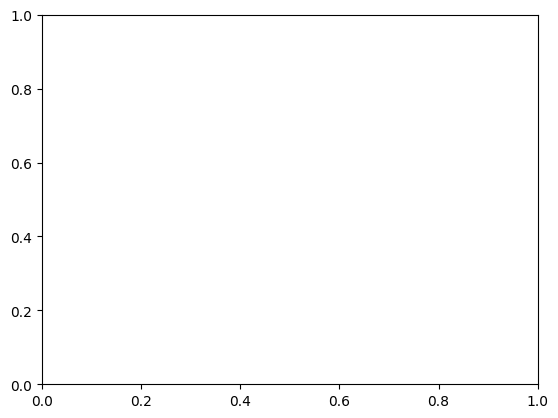

In [18]:
plt.plot( range(Epochs), all_lossesA, label='Model A Loss')
plt.plot( range(Epochs),all_lossesB, label='Model B Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(all_lossesA, label='Model A Loss', linestyle='dashed', marker='o')
plt.plot(all_lossesB, label='Model B Loss', linestyle='dashed', marker='s')
plt.xlabel("Batch Iterations")
plt.ylabel("Loss")
plt.title("Loss Trends Over Training")
plt.legend()
# plt.grid()
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
epochs = range(1, Epochs+1)
plt.plot(epochs, accuracy_listA, label="Model A Accuracy", marker='o')
plt.plot(epochs, accuracy_listB, label="Model B Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, pruned_samplesA, label="Model A Retained Samples", marker='o')
plt.plot(epochs, pruned_samplesB, label="Model B Retained Samples", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Retained Samples")
plt.title("Effect of Rank Pruning Over Epochs")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np

# Calculate the average loss per epoch for Model A
epoch_lossesA = np.array(all_lossesA).reshape(Epochs, -1).mean(axis=1)

# Calculate the average loss per epoch for Model B
epoch_lossesB = np.array(all_lossesB).reshape(Epochs, -1).mean(axis=1)

# Plot the average losses per epoch
plt.plot(range(Epochs), epoch_lossesA, label='Model A Loss')
plt.plot(range(Epochs), epoch_lossesB, label='Model B Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# # Training Function for Co-Teaching
# def co_teaching_train(modelA, modelB, train_loader, epochs=10, noise_level=noise_rate):
#     optimizerA = torch.optim.Adam(modelA.parameters(), lr=0.0003)
#     optimizerB = torch.optim.Adam(modelB.parameters(), lr=0.0003)
#     criterion = SymmetricCrossEntropyLoss().to(device)
#     all_labelsA, all_labelsB = [], []
#     all_probsA, all_probsB = [], []
#     all_lossesA, all_lossesB = [], []
#     all_predictionsA, all_predictionsB = [], []

#     for epoch in range(epochs):
#         modelA.train()
#         modelB.train()

#         running_lossA, running_lossB = 0.0, 0.0
#         correctA, correctB = 0.0, 0.0

#         forget_rate = forget_rate_scheduler(epoch, epochs)

#         for images, labels in tqdm(train_loader):
#             images, labels = images.to(device), labels.view(-1).long().to(device)

#             optimizerA.zero_grad()
#             optimizerB.zero_grad()

#             # Forward Pass
#             outputsA = modelA(images)
#             outputsB = modelB(images)

#             # Apply dynamic rank pruning
#             maskA = rank_pruning(outputsA, labels, keep_ratio=forget_rate)
#             maskB = rank_pruning(outputsB, labels, keep_ratio=forget_rate)

#             # Apply co-teaching: Each model trains on the other’s selected samples
#             if maskA.sum() > 0 and maskB.sum() > 0:
#                 lossA_filtered = criterion(outputsA[maskB], labels[maskB])
#                 lossB_filtered = criterion(outputsB[maskA], labels[maskA])
#             else:
#                 lossA_filtered = torch.tensor(0.0, requires_grad=True).to(device)
#                 lossB_filtered = torch.tensor(0.0, requires_grad=True).to(device)

#             # Backpropagation
#             lossA_filtered.backward()
#             lossB_filtered.backward()
#             optimizerA.step()
#             optimizerB.step()

#             running_lossA += lossA_filtered.item()
#             running_lossB += lossB_filtered.item()

#             # Compute Accuracy
#             _, predictedA = torch.max(outputsA, 1)
#             _, predictedB = torch.max(outputsB, 1)

#             correctA += (predictedA == labels).sum().item()
#             correctB += (predictedB == labels).sum().item()

#             all_labelsA.extend(labels.cpu().numpy())
#             all_labelsB.extend(labels.cpu().numpy())

#             # all_probsA.extend(torch.softmax(outputsA, dim=1).cpu().numpy())
#             # all_probsB.extend(torch.softmax(outputsB, dim=1).cpu().numpy())
#            # We now detach the tensor from the computation graph prior to converting to numpy
#             all_probsA.extend(outputsA.detach().cpu().numpy()) # detach
#             all_probsB.extend(outputsB.detach().cpu().numpy()) # detach

#             all_lossesA.append(lossA_filtered.detach().cpu().numpy().item()) # detach and extract scalar
#             all_lossesB.append(lossB_filtered.detach().cpu().numpy().item()) # detach and extract scalar


#             all_predictionsA.extend(predictedA.cpu().numpy())
#             all_predictionsB.extend(predictedB.cpu().numpy())


#         # Compute final accuracy
#         accuracyA = 100 * correctA / len(train_loader.dataset)
#         accuracyB = 100 * correctB / len(train_loader.dataset)

#         print(f"Epoch {epoch+1}/{epochs} - LossA: {running_lossA/len(train_loader):.4f}, LossB: {running_lossB/len(train_loader):.4f}, AccuracyA: {accuracyA:.2f}%, AccuracyB: {accuracyB:.2f}%")

# # Train Co-Teaching Model
# co_teaching_train(modelA, modelB, train_loader, epochs=Epochs, noise_level=noise_rate)


In [ ]:
modelB.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device),labels.to(device)
        outputs = modelB(images)
        _, predicted = torch.max(outputs.data, 1)
        labels = labels.squeeze()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100*correct/total
    print(f"Accuracy for noise rate: {noise_rate} is {accuracy}%")


In [ ]:
# # Initialize epoch-level tracking
# epoch_lossesA, epoch_lossesB = [], []
# epoch_accuraciesA, epoch_accuraciesB = [], []

# # For AUC (collect across all epochs)
# all_labels = []
# all_probsA, all_probsB = [], []

# for epoch in range(Epochs):
#     modelA.train()
#     modelB.train()

#     # Per-epoch accumulators
#     epoch_lossA, epoch_lossB = 0.0, 0.0
#     correctA, correctB = 0, 0
#     forget_rate = forget_rate_scheduler(epoch, Epochs)

#     for images, labels in tqdm(train_loader):

#         images, labels = images.to(device), labels.view(-1).long().to(device)

#         optimizerA.zero_grad()
#         optimizerB.zero_grad()

#         # Forward Pass
#         outputsA = modelA(images)
#         outputsB = modelB(images)

#         # Apply dynamic rank pruning
#         maskA = rank_pruning(outputsA, labels, keep_ratio=forget_rate)
#         maskB = rank_pruning(outputsB, labels, keep_ratio=forget_rate)

#         # Apply co-teaching: Each model trains on the other’s selected samples
#         if maskA.sum() > 0 and maskB.sum() > 0:
#             lossA_filtered = criterion(outputsA[maskB], labels[maskB])
#             lossB_filtered = criterion(outputsB[maskA], labels[maskA])
#         else:
#             lossA_filtered = torch.tensor(0.0, requires_grad=True).to(device)
#             lossB_filtered = torch.tensor(0.0, requires_grad=True).to(device)

#         # Backpropagation
#         lossA_filtered.backward()
#         lossB_filtered.backward()
#         optimizerA.step()
#         optimizerB.step()

#         running_lossA += lossA_filtered.item()
#         running_lossB += lossB_filtered.item()

#         # Compute Accuracy
#         _, predictedA = torch.max(outputsA, 1)
#         _, predictedB = torch.max(outputsB, 1)

#         correctA += (predictedA == labels).sum().item()
#         correctB += (predictedB == labels).sum().item()

#         all_labelsA.extend(labels.cpu().numpy())
#         all_labelsB.extend(labels.cpu().numpy())

#         # Store probabilities with softmax
#         all_probsA.extend(torch.softmax(outputsA, dim=1).detach().cpu().numpy())
#         all_probsB.extend(torch.softmax(outputsB, dim=1).detach().cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

#     # Calculate epoch metrics
#     epoch_lossA = running_lossA / len(train_loader)
#     epoch_lossB = running_lossB / len(train_loader)
#     epoch_lossesA.append(epoch_lossA)
#     epoch_lossesB.append(epoch_lossB)

#     accuracyA = 100 * correctA / len(train_loader.dataset)
#     accuracyB = 100 * correctB / len(train_loader.dataset)
#     epoch_accuraciesA.append(accuracyA)
#     epoch_accuraciesB.append(accuracyB)

# # Correct Visualization
# plt.figure(figsize=(10, 5))
# plt.plot(epoch_lossesA, label='Model A Loss')
# plt.plot(epoch_lossesB, label='Model B Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(epoch_accuraciesA, label='Model A Accuracy')
# plt.plot(epoch_accuraciesB, label='Model B Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.legend()
# plt.show()

# # Correct AUC Calculation
# all_labels = np.array(all_labels)
# all_probsA = np.array(all_probsA)
# all_probsB = np.array(all_probsB)

# # For multi-class AUC with raw labels
# try:
#     aucA = roc_auc_score(all_labels, all_probsA, multi_class='ovr')
#     aucB = roc_auc_score(all_labels, all_probsB, multi_class='ovr')
#     print(f"AUC - Model A: {aucA:.4f}, Model B: {aucB:.4f}")
# except ValueError as e:
#     print(f"AUC calculation error: {str(e)}")

In [ ]:
# optimizerA = torch.optim.Adam(modelA.parameters(), lr=0.0003)
# optimizerB = torch.optim.Adam(modelB.parameters(), lr=0.0003)
# criterion = SymmetricCrossEntropyLoss().to(device)

# all_labelsA, all_labelsB = [], []
# all_probsA, all_probsB = [], []
# all_lossesA, all_lossesB = [], []
# all_predictionsA, all_predictionsB = [], []

# for epoch in range(Epochs):
#     modelA.train()
#     modelB.train()

#     running_lossA, running_lossB = 0.0, 0.0
#     correctA, correctB = 0.0, 0.0

#     forget_rate = forget_rate_scheduler(epoch, Epochs)

#     for images, labels in tqdm(train_loader):
#         images, labels = images.to(device), labels.view(-1).long().to(device)

#         optimizerA.zero_grad()
#         optimizerB.zero_grad()

#         # Forward Pass
#         outputsA = modelA(images)
#         outputsB = modelB(images)

#         # Apply dynamic rank pruning
#         maskA = rank_pruning(outputsA, labels, keep_ratio=forget_rate)
#         maskB = rank_pruning(outputsB, labels, keep_ratio=forget_rate)

#         # Apply co-teaching: Each model trains on the other’s selected samples
#         if maskA.sum() > 0 and maskB.sum() > 0:
#             lossA_filtered = criterion(outputsA[maskB], labels[maskB])
#             lossB_filtered = criterion(outputsB[maskA], labels[maskA])
#         else:
#             lossA_filtered = torch.tensor(0.0, requires_grad=True).to(device)
#             lossB_filtered = torch.tensor(0.0, requires_grad=True).to(device)

#         # Backpropagation
#         lossA_filtered.backward()
#         lossB_filtered.backward()
#         optimizerA.step()
#         optimizerB.step()

#         running_lossA += lossA_filtered.item()
#         running_lossB += lossB_filtered.item()

#         # Compute Accuracy
#         _, predictedA = torch.max(outputsA, 1)
#         _, predictedB = torch.max(outputsB, 1)

#         correctA += (predictedA == labels).sum().item()
#         correctB += (predictedB == labels).sum().item()

#         all_labelsA.extend(labels.cpu().numpy())
#         all_labelsB.extend(labels.cpu().numpy())

#         # all_probsA.extend(torch.softmax(outputsA, dim=1).cpu().numpy())
#         # all_probsB.extend(torch.softmax(outputsB, dim=1).cpu().numpy())
#         # We now detach the tensor from the computation graph prior to converting to numpy
#         all_probsA.extend(outputsA.detach().cpu().numpy()) # detach
#         all_probsB.extend(outputsB.detach().cpu().numpy()) # detach

#         all_lossesA.append(lossA_filtered.detach().cpu().numpy().item()) # detach and extract scalar
#         all_lossesB.append(lossB_filtered.detach().cpu().numpy().item()) # detach and extract scalar


#         all_predictionsA.extend(predictedA.cpu().numpy())
#         all_predictionsB.extend(predictedB.cpu().numpy())


#     # Compute final accuracy
#     accuracyA = 100 * correctA / len(train_loader.dataset)
#     accuracyB = 100 * correctB / len(train_loader.dataset)

#     print(f"Epoch {epoch+1}/{Epochs} - LossA: {running_lossA/len(train_loader):.4f}, LossB: {running_lossB/len(train_loader):.4f}, AccuracyA: {accuracyA:.2f}%, AccuracyB: {accuracyB:.2f}%")

# #visualise

# plt.plot(range(Epochs), all_lossesA, label='Model A Loss')
# plt.plot( range(Epochs),all_lossesB, label='Model B Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.plot(range(Epochs), all_predictionsA, label='Model A Predictions')
# plt.plot(range(Epochs), all_predictionsB, label='Model B Predictions')
# plt.xlabel('Epoch')
# plt.ylabel('Predictions')
# plt.legend()
# plt.show()

# plt.plot(range(Epochs), all_labelsA, label='Model A Labels')
# plt.plot(range(Epochs), all_labelsB, label='Model B Labels')
# plt.xlabel('Epoch')
# plt.ylabel('Labels')
# plt.legend()
# plt.show()

# plt.plot(range(Epochs), all_probsA, label='Model A Probabilities')
# plt.plot(range(Epochs), all_probsB, label='Model B Probabilities')
# plt.xlabel('Epoch')
# plt.ylabel('Probabilities')
# plt.legend()
# plt.show()

# from sklearn.metrics import roc_auc_score


# all_probsA_np = np.array(all_probsA)

# auc = roc_auc_score(all_labelsA, all_probsA_np, multi_class='ovr') # Specify 'ovr' for multi-class
# print(f"AUC for Model A: {auc}")

In [ ]:
modelA.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = modelA(images)

        _, predicted = torch.max(outputs.data, 1)
        labels = labels.squeeze()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

In [ ]:
modelA = SimpleQNN(num_classes=11).to(device)
modelB = PureQNN(num_classes=11).to(device)
criterion = SymmetricCrossEntropyLoss()

In [ ]:
def co_teaching_train_step(modelA, modelB, optimizerA, optimizerB, images, labels, noise_level=0.2):
    """
    Perform one co-teaching training step with two QNN models.
    """
    modelA.train()
    modelB.train()

    # Forward Pass (Model A)
    optimizerA.zero_grad()
    outputsA = modelA(images)
    maskA = rank_pruning(outputsA, labels, keep_ratio=1 - noise_level)

    # Forward Pass (Model B)
    optimizerB.zero_grad()
    outputsB = modelB(images)
    maskB = rank_pruning(outputsB, labels, keep_ratio=1 - noise_level)

    # Co-Teaching: Each model trains on the other's clean samples
    lossA = nn.CrossEntropyLoss()(outputsA[maskB], labels[maskB])
    lossB = nn.CrossEntropyLoss()(outputsB[maskA], labels[maskA])

    # Backpropagation
    lossA.backward()
    optimizerA.step()
    lossB.backward()
    optimizerB.step()

    return lossA.item(), lossB.item()


In [ ]:
def train_co_teaching(modelA, modelB, train_loader, epochs=10, noise_level=0.2):
    optimizerA = torch.optim.Adam(modelA.parameters(), lr=0.001)
    optimizerB = torch.optim.Adam(modelB.parameters(), lr=0.001)

    for epoch in range(epochs):
        running_lossA, running_lossB = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Perform co-teaching training step
            lossA, lossB = co_teaching_train_step(modelA, modelB, optimizerA, optimizerB, images, labels, noise_level)

            running_lossA += lossA
            running_lossB += lossB



        print(f"Epoch {epoch+1}/{epochs} - LossA: {running_lossA:.4f}, LossB: {running_lossB:.4f}")

    print("Training Complete!")


In [ ]:
def co_teaching(train_loader, model1, model2, optimizer, criterion, epoch, num_epochs):
    model1.train()
    model2.train()
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs1 = model1(inputs)
        outputs2 = model2(inputs)


        # Compute loss
        loss1 = criterion(outputs1, labels)
        loss2 = criterion(outputs2, labels)

        # Select small loss samples
        _, indices1 = torch.topk(loss1, k=int(0.8 * len(loss1)), largest=False)
        _, indices2 = torch.topk(loss2, k=int(0.8 * len(loss2)), largest=False)

        # Update models using small loss samples (compute mean loss)
        loss1 = criterion(outputs1[indices2], labels[indices2]).mean()  # Scalar
        loss2 = criterion(outputs2[indices1], labels[indices1]).mean()  # Scalar

        loss1.backward()
        loss2.backward()
        optimizer.step()


# Define optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam([
#     {"params": model.conv1.parameters(), "lr": 0.001},
#     {"params": model.conv2.parameters(), "lr": 0.001},
#     {"params": model.fc1.parameters(), "lr": 0.001},
#     {"params": model.quantum_layer.parameters(), "lr": 0.0001},  # Smaller LR for quantum
#     {"params": model.fc2.parameters(), "lr": 0.001},
# ])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model
num_epochs = Epochs
for epoch in range(num_epochs):
    co_teaching(train_loader, model, model, optimizer, criterion, epoch, num_epochs)
    scheduler.step()
    print(f'Epoch {epoch+1}/{num_epochs} completed.')

In [ ]:
# Evaluate the model
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Flatten the labels (MedMNIST labels are 2D)
            labels = labels.squeeze()  # Convert shape [batch_size, 1] → [batch_size]

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

evaluate(model, test_loader)